# horsing around with the backprop algorithm
Marcus started this see how quickly he could get backprop to stand up.

Note the use of "checkgrad", which exhaustively confirms that the gradient calculation is in fact correct - not something to run all the time but a useful check to have.

Issues:
  * the neural net has no biases yet
  * the learning problem is just random - better if we could read in a training set

In [2]:
import numpy as np
import numpy.random as rng
import sklearn
import sklearn.datasets as ds
import sklearn.cross_validation as cv
import sklearn.neighbors as nb
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
%matplotlib inline
np.set_printoptions(precision = 2, suppress = True)

### Specify some neuron transfer functions and their derivatives

In [3]:
def sigmoid(phi):
    """Calculates the sigmoid of phi.
    
    phi - A matrix of weighted inputs i.e. np.dot(W, X).
    """
    neg_phi = -1 * phi
    
    return (1.0 / (1.0 + np.exp(neg_phi)))

def grad_sigmoid(x):
    """Calculates the gradient of the sigmoid function at point x. Note that
    this is hard coded to correspond directly to the sigmoid(phi) function
    above.
    
    x - The value of sigmoid(phi) for some phi that we wish to know
        the gradient of.
    """
    return (x * (1 - x))
    
def relu(phi):
    """Rectified linear transfer function (ReLU).
    
    phi - A matrix of weighted inputs i.e. np.dot(W, X).
    """
    return phi * (phi > 0.0)

def grad_relu(x):
    """Calculates the gradient of the relu function at point x.
    
    x - The value of relu(phi) for some phi that we wish to know
    the gradient of."""
    return 1.0 * (x > 0.0)

In [4]:
# TODO - implement a softmax transfer function.
def softmax(phi):
    ret = np.zeros(shape=phi.shape)
    for x in range(0, phi.shape[0]):
        e_x = np.exp(phi[x,:] - np.max(phi[x,:]))
        ret[x,:] = (e_x / e_x.sum())
    
    return ret

def grad_softmax(phi):
    """The gradient of the softmax is phi * (1 - phi) on the
    diagonals, and phi * (0 - phi) on the off-diagonals.
    """
    ret = np.zeros(shape=phi.shape)
    for i in range(ret.shape[0]):
        for j in range(ret.shape[1]):
            if i == j:
                ret[i, j] = phi[i, j] * (1 - phi[i, j])
            else:
                ret[i, j] = -1 * phi[i, j] * phi[i, j]
    return ret

### Get some training data

In [5]:
def one_hot(X, ndim):
    """Transforms a vector of real valued targets to a one-hot
    target matrix.
    """
    out = np.zeros(shape=(X.shape[0], ndim))
    for i in range(0, X.shape[0]):
        row = np.zeros(shape=(1, ndim))
        row[0, X[i]] = 1
        out[i] = row
        
    return out

In [6]:
# Load the sklearn digits data set.
digits = ds.load_digits()
inputX = digits.data
targ = digits.target

# Note that targ is currently a vector, but we want a n x 10 matrix,
# and so we reshape and then squeeze it into a one-hot distribution.
targ = np.reshape(targ, (len(targ), 1))
targ = one_hot(targ, ndim=10)

print(inputX.shape, targ.shape)
print(inputX.min(), inputX.max())

(1797, 64) (1797, 10)
0.0 16.0


### The function we're climbing

In [7]:
def calc_goodness(Y, targets):
    """Often this is called the "Loss" or the "Cost function" (and 
    given a minus sign accordingly).
    
    Y -
    targets -
    
    returns good_vec.sum() -
            good_vec -
            dgood -
    """
    error = targets - Y
    
    # Inverted parabola centered on the target outputs.
    good_vec = -0.5 * np.power(error, 2.0)
    
    # dGood_vec is the (direction? delta?) of something - if output
    # is too low, it will be positive.
    dgood = error 
    
    return good_vec.sum(), good_vec, dgood

### set the network's architecture

In [8]:
# We have n examples from our inputX data. Each example has inputX.shape[1]
# dimensions, and so we need inputX.shape[1] neurons in our input layer.
# There are targ.shape[1] different output dimensions, and so we need
# targ.shape[1] neurons in our output layer.
input_dimensions = inputX.shape[1]
output_dimensions = 10

architecture = [input_dimensions, 15, 15, output_dimensions]

print("There are this many neurons in each layer: ", architecture)

There are this many neurons in each layer:  [64, 15, 15, 10]


In [9]:
# X is going to be a list giving the activations of successive layers. 
# Each element in X is a matrix, whose columns are the neurons in the
# layer corresponding to the elements index within X. Each row in the
# matrix corresponds to a training item, so all the matrices in X will
# have the same number of rows.
X = [inputX]
n = inputX.shape[0] # The number of examples that we have.

for L in range(1, len(architecture)):
    X.append(np.zeros(shape=(n, architecture[L]), dtype=float))

for L in range(len(architecture)): 
    print("layer", L, "activations have shape", X[L].shape)

layer 0 activations have shape (1797, 64)
layer 1 activations have shape (1797, 15)
layer 2 activations have shape (1797, 15)
layer 3 activations have shape (1797, 10)


### Set up the weights

In [10]:
# Let's index weight layer by the layer they're *going* towards.

# Initialise the zero'th weight layers. W is a list of matrices. The element
# at index i has the same number of rows as the number of columns in X[i]. i.e.
# there is one row for each neuron in the layer that the weights are *going*
# towards. Similarly, there is a column for each neuron in the layer that the
# weights are *coming* from.
W  = [np.array(None)]
dW = [np.array(None)]

init_weights_scale = 0.1  # 1 / np.sqrt((X[L].shape()).max())

for layer in range(1, len(X)):
    # There is a weight from each neuron in the previous layer to each neuron
    # in the current layer.
    in_dimension = X[layer - 1].shape[1]
    out_dimension = X[layer].shape[1]
    
    W.append(init_weights_scale * rng.normal(0, 1, size=(out_dimension, in_dimension)))
    
    # The change in weights is initially zero, although we want to maintain
    # the dimensionality of the weights matrix that we just constructed.
    dW.append(0.0 * np.copy(W[layer]))

for L in range(len(W)):
    print("layer", L, "weights have shape", W[L].shape)

layer 0 weights have shape ()
layer 1 weights have shape (15, 64)
layer 2 weights have shape (15, 15)
layer 3 weights have shape (10, 15)


### Forward pass

In [11]:
def forward_pass(X, W):
    """Takes the inputs to each layer, evaluates them with the 
    corresponding weights and then calculates the activation of
    each neuron using the sigmoid function. No learning is done
    at this stage, only evaluation of parameters.
    
    X - A list of matrices describing the inputs to each layer. The
        inputs to the first layer (the input layer) is X[0]. In
        general, the input to layer i is X[i - 1].
    W - List of matrices describing the weights between each layer.
        The weights *going* to layer i are indexed by W[i].
        
    returns X - the input X with new activations.
    """
    for layer in range(1, len(X)):
        # Grab the inputs to this layer, and transpose so that we
        # can take the dot product of them with the corresponding
        # weights.
        inputs = X[layer - 1].transpose()
        weighted_inputs = np.dot(W[layer], inputs).transpose()
        
        # The activations (outputs) of this layer are defined by the
        # transfer function.
        if layer < len(X) - 1:
            X[layer] = sigmoid(weighted_inputs)
        else:
            # Perform softmax across final layer.
            X[layer] = softmax(weighted_inputs)
    
    return X

### backward pass

In [12]:
def backward_pass(X, W, dW, targets):
    """Evaluates the error of the model, based on the calc_goodness
    function and determines the direction and the magnitude of the
    weight change needed to optimise.
    
    X - A list of matrices describing the inputs to each layer. The
        inputs to the first layer (the input layer) is X[0]. In
        general, the input to layer i is X[i - 1].
    W - List of matrices describing the weights between each layer.
        The weights *going* to layer i are indexed by W[i].
    dW - A list of matrices containing the deltas to each weight layer.
    targets - An n x 1 matrix containing the target class for each
              example.
    
    returns dW -
    """
    good_sum, good_vec, dgood = calc_goodness(X[-1], targets)
    epsilon = dgood
    npats = X[0].shape[0]
    
    # Then every other layer.
    for layer in range(len(X) - 1, 0, -1):
        if layer < len(X) - 1:
            psi = epsilon * grad_sigmoid(X[layer]) # Element-wise multiply.
        else:
            psi = epsilon * grad_softmax(X[layer])
        n1 = X[layer - 1].shape[1]
        n2 = psi.shape[1]
        A = np.tile(X[layer - 1], n2).reshape(npats, n2, n1)
        B = np.repeat(psi, n1).reshape(npats, n2, n1)
        dW[layer] = (A * B).sum(0) # Outer product multiply.
        epsilon = np.dot(psi, W[layer]) # Inner product multiply.
        
    return dW

In [13]:
X = forward_pass(X, W)
dW = backward_pass(X, W, dW, targ)

In [14]:
def checkgrad(dW, X, W, targets):
    """Calculates the gradient directly, via pertubations to every weight.
    This is completely daft in practical terms, but is very useful for debugging
    as it tells us whether the backprop of errors is returning the true gradient.
    
    dW -
    X -
    W -
    targets -
    
    returns None
    """
    epsilon = 0.0001
    
    dW_test = [np.array(None)]
    for L in range(1,len(W)):
        dW_test.append(0.0*np.copy(W[L]))
    
    X = forward_pass(X, W)
    base_good, tmp1, tmp2 = calc_goodness(X[-1], targets)
    
    for layer in range(1, len(X)):
        # For each destination node.
        for j in range(W[layer].shape[0]):
            # For each origin node.
            for i in range(W[layer].shape[1]):
                # Perturb the weight from (layer - 1, i) -> (layer, j).
                (W[layer])[j, i] += epsilon
                # Compute and store the empirical gradient estimate.
                X = forward_pass(X, W)
                tmp_good, tmp1, tmp2 = calc_goodness(X[-1], targets)
                (dW_test[layer])[j, i] = (tmp_good - base_good) / epsilon                
                # Unperturb the weight.
                (W[layer])[j, i] -= epsilon
                
    # Print the results for analysis.
    for L in range(1, len(X)):
        print ('-------------- layer %d --------------' %(L))
        print ('calculated gradients:')
        print (dW[L])
        print ('empirical gradients:')
        print (dW_test[L])

In [15]:
checkgrad(dW, X, W, targ)

-------------- layer 1 --------------
calculated gradients:
[[ 0.    0.    0.02  0.02  0.01  0.02  0.01 -0.   -0.    0.01  0.03  0.
   0.01  0.02  0.   -0.   -0.    0.01  0.02 -0.01 -0.01 -0.   -0.   -0.   -0.
   0.01  0.02  0.   -0.01 -0.   -0.   -0.    0.   -0.   -0.   -0.02 -0.03
   0.    0.01  0.   -0.   -0.   -0.01 -0.03 -0.02  0.01  0.02  0.   -0.    0.
   0.01 -0.   -0.    0.02  0.01 -0.   -0.    0.    0.02  0.02  0.01  0.01
  -0.   -0.  ]
 [ 0.   -0.01 -0.05 -0.02 -0.04 -0.08 -0.03 -0.    0.   -0.01 -0.05 -0.01
   0.01  0.   -0.01 -0.    0.   -0.03 -0.05  0.02  0.06  0.05  0.01  0.    0.
  -0.04 -0.07 -0.01  0.02  0.01 -0.    0.    0.   -0.02 -0.03  0.02  0.
  -0.02 -0.01  0.    0.    0.    0.04  0.04 -0.02 -0.03  0.01  0.    0.   -0.
   0.02  0.01 -0.04  0.    0.03  0.    0.   -0.01 -0.05 -0.03  0.03  0.06
   0.03  0.  ]
 [ 0.    0.    0.01  0.04  0.04  0.03  0.01  0.   -0.   -0.    0.02  0.05
   0.04  0.02  0.    0.    0.   -0.    0.01  0.04  0.02 -0.   -0.   -0.    0.
   0.0

## yay.
The gradient seems to be right for the full MLP, so that's... progress!

Let's try learning the problem then....

In [16]:
def learn(X, W, dW, targets, learning_rate=0.01, momentum=0.1, num_steps=1):
    # note dW and prev_change are of the same size as W - we'll make space for them first
    times, vals = [], []
    next_time = 0
    
    prev_change = [np.array(None)]
    for L in range(1,len(X)):
        prev_change.append(0.0 * np.copy(W[L]))
    
    # now for the learning iterations
    for step in range(num_steps):
        X = forward_pass(X,W)
        
        # this is just record-keeping.......
        if step == next_time:
            good_sum, good_vec, dgood = calc_goodness(X[-1], targets)
            vals.append(good_sum)
            times.append(step)
            next_time = step + 10

        dW = backward_pass(X, W, dW, targets)
        for L in range(1,len(X)):
            change =  (learning_rate * dW[L]) + (momentum * prev_change[L])
            W[L] = W[L] + change
            prev_change[L] = change


    return W, times, vals

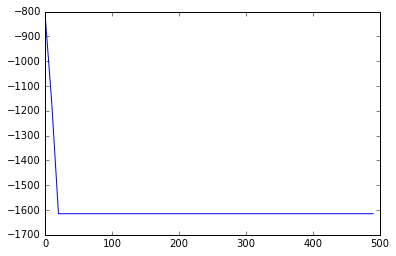

In [17]:
W, times, vals = learn(X, W, dW, targ, learning_rate=0.01, momentum=0.5, num_steps=500)
plt.plot(times, vals)

# Discussion

This code never got around to properly working correctly. I believe that the problem lies with pushing the gradients back through the softmax function. As shown in the previous section, the gradient of the softmax function is equal to $y_i(1 - y_i)$ on the diagonals and $-y_iy_j$ on the off-diagonals. I believe that my implementation captures this, although something that is yet unidentified is fundamentally wrong (at least judging by the error graph produced above).

__Sigmoids vs. Relus__

In light of the strife outlined above, I didn't get to produce an analysis of whether sigmoids or relus result in a higher classification accuracy, or enable the neural net to be trained quicker in this particular application on the digits data set. 

Theoretically, since the relu function has a non-saturating gradient, the network using relus will converge orders of magnitude faster (due to the gradients of any activations being equal to 1, instead of arbitrarily small values as in the case of the sigmoid). Results in literature confirm this faster convergence.

As for whether a network trained with sigmoids or relus will converge on a _better_ solution? That's a non-trivial question. Intuitively, a larger gradient means larger updates to each weight per cycle (this can be seen by the delta rule from part 2 of the assignment). This is great in the early training stages, although leaves open the possibility of 'skipping past' optima (or oscillating around optima) in the final stages of training. Because of this fact, a decaying momentum rate  seems like a good idea when training a network using relus as the magnitude of weight updates can then be decreased over time.